In [31]:
import os
import numpy as np
import cv2
import rasterio
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.optimizers import Adam
from scipy.ndimage import label
from skimage.measure import regionprops

In [32]:
# Directory containing .tif images
IMAGE_DIR = "E:/tif images and csv/images"  # Replace with your actual directory

In [33]:
# Function to load .tif images
def load_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3])  # Red, Green, Blue bands
        image = np.moveaxis(image, 0, -1)  # Change shape to (height, width, 3)
    return image

In [34]:
# Function to calculate NDVI
def calculate_ndvi(image_path):
    with rasterio.open(image_path) as src:
        red = src.read(3).astype(float)
        nir = src.read(4).astype(float)
        ndvi = (nir - red) / (nir + red + 1e-7)
    return ndvi

In [35]:
# Function to create binary mask from NDVI
def create_mask_from_ndvi(ndvi, threshold=0.4):
    return np.where(ndvi > threshold, 1, 0)

In [36]:
# Function to preprocess data
def preprocess_data(image_paths, img_size=(256, 256), threshold=0.4):
    images, masks = [], []
    for img_path in image_paths:
        image = load_image(img_path)
        image_resized = cv2.resize(image, img_size)
        ndvi = calculate_ndvi(img_path)
        mask = create_mask_from_ndvi(ndvi, threshold)
        mask_resized = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
        images.append(image_resized / 255.0)  # Normalize images
        masks.append(mask_resized.astype(np.float32))  # Convert masks to float
    return np.array(images), np.array(masks)

In [37]:
# Define weighted binary cross-entropy loss
def weighted_binary_crossentropy(y_true, y_pred):
    weight_for_1 = 5.0  # Weight for tree pixels
    weight_for_0 = 1.0  # Weight for non-tree pixels
    loss = -(weight_for_1 * y_true * K.log(y_pred + 1e-7) + weight_for_0 * (1 - y_true) * K.log(1 - y_pred + 1e-7))
    return K.mean(loss)

In [38]:
# Build U-Net model
def build_unet(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c4)
    u1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.concatenate([u1, c3])

    u2 = layers.UpSampling2D((2, 2))(u1)
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.concatenate([u2, c2])

    u3 = layers.UpSampling2D((2, 2))(u2)
    u3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.concatenate([u3, c1])

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u3)
    model = models.Model(inputs, outputs)
    return model

In [39]:
# Load images and split dataset
image_paths = [os.path.join(IMAGE_DIR, fname) for fname in os.listdir(IMAGE_DIR) if fname.endswith('.tif')]
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
train_images, train_masks = preprocess_data(train_paths)
test_images, test_masks = preprocess_data(test_paths)

In [40]:
# Display the number of images in train and test splits
print(f"Number of images in the training set: {len(train_paths)}")
print(f"Number of images in the testing set: {len(test_paths)}")

Number of images in the training set: 1320
Number of images in the testing set: 331


In [ ]:
# # Build and compile the model
# unet_model = build_unet()
# unet_model.compile(optimizer=Adam(), loss=weighted_binary_crossentropy, metrics=['accuracy'])

# # Train the model
# history = unet_model.fit(
#     train_images, train_masks,
#     epochs=5,
#     batch_size=8,
#     validation_data=(test_images, test_masks)
# )

# Save the trained model
#unet_model.save("tree_count_model2.keras")

Epoch 1/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 2804s 17s/step - accuracy: 0.9169 - loss: 0.6005 - val_accuracy: 0.9203 - val_loss: 0.2409
Epoch 2/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 2868s 17s/step - accuracy: 0.9377 - loss: 0.2191 - val_accuracy: 0.9602 - val_loss: 0.2052
Epoch 3/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 2795s 17s/step - accuracy: 0.9428 - loss: 0.2013 - val_accuracy: 0.9202 - val_loss: 0.2076
Epoch 4/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 2834s 17s/step - accuracy: 0.9463 - loss: 0.1870 - val_accuracy: 0.9037 - val_loss: 0.2414
Epoch 5/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 3445s 21s/step - accuracy: 0.9435 - loss: 0.1956 - val_accuracy: 0.9565 - val_loss: 0.1889


In [52]:
unet_model = tf.keras.models.load_model('E:/unet model/unet model ipynb/tree_count_model2.keras', custom_objects={'weighted_binary_crossentropy': weighted_binary_crossentropy})

In [53]:
# Function to predict mask
from skimage.morphology import closing, disk

def post_process_mask(mask):
    # Perform morphological closing to remove small holes in the mask
    mask = closing(mask, disk(3))  # You can adjust the size of the disk
    return mask

def predict_mask(image_path, model, img_size=(256, 256), threshold=0.6):
    image = load_image(image_path)
    image_resized = cv2.resize(image, img_size) / 255.0
    image_input = np.expand_dims(image_resized, axis=0)
    predicted_mask = model.predict(image_input)[0, :, :, 0]
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    return post_process_mask(binary_mask)

In [54]:
# Function to count trees
def count_trees(binary_mask):
    # Ensure binary_mask is 2D
    if binary_mask.ndim == 3:
        binary_mask = np.squeeze(binary_mask, axis=-1)
    labeled_mask, num_features = label(binary_mask, structure=np.ones((3, 3)))
    regions = regionprops(labeled_mask)
    return sum(1 for region in regions if region.area > 10)

In [55]:
import matplotlib.pyplot as plt

# Function to display the original image, predicted mask, and tree count
def display_results(image_path, predicted_mask, tree_count):
    # Load the original image
    original_image = load_image(image_path)

    # Plot the results side by side
    plt.figure(figsize=(15, 5))

    # Display the original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    # Display the predicted mask
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    # Display the tree count
    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, f"Tree Count: {tree_count}", fontsize=20, ha='center', va='center')
    plt.title("Tree Count")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [61]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Assuming test_images and test_masks are your test data and ground truth masks
# Predict the mask using your model
predicted_mask = unet_model.predict(test_images)  # Replace with actual prediction logic

# If the prediction is a probability map, threshold it to binary
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

# Flatten the ground truth mask and predicted mask to 1D arrays
y_true = test_masks.ravel()  # Use ravel() or flatten() on the arrays
y_pred = predicted_mask.ravel()

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Classification Report
report = classification_report(y_true, y_pred, target_names=['Non-Tree', 'Tree'])

# Print Results
print(f"Accuracy: {accuracy * 100:.2f}%\n")
print(f"Confusion Matrix:\n{cm}\n")
print(f"Classification Report:\n{report}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 172s 16s/step
Accuracy: 95.65%

Confusion Matrix:
[[19199572   766853]
 [  177175  1548816]]

Classification Report:
              precision    recall  f1-score   support

    Non-Tree       0.99      0.96      0.98  19966425
        Tree       0.67      0.90      0.77   1725991

    accuracy                           0.96  21692416
   macro avg       0.83      0.93      0.87  21692416
weighted avg       0.97      0.96      0.96  21692416



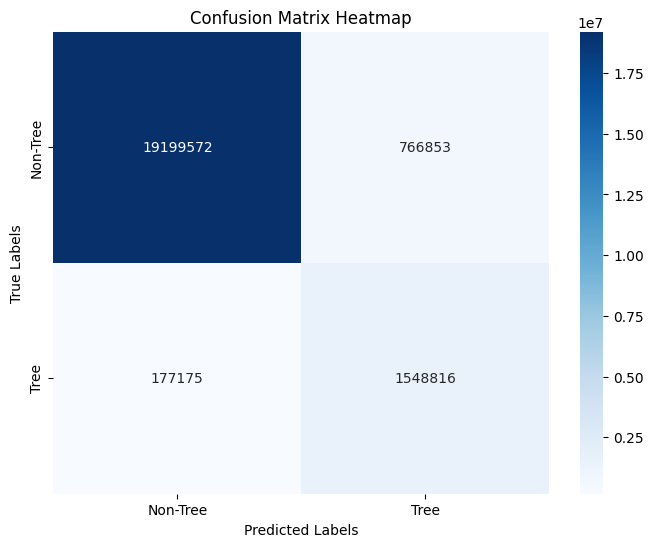

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Non-Tree', 'Tree'], yticklabels=['Non-Tree', 'Tree'])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


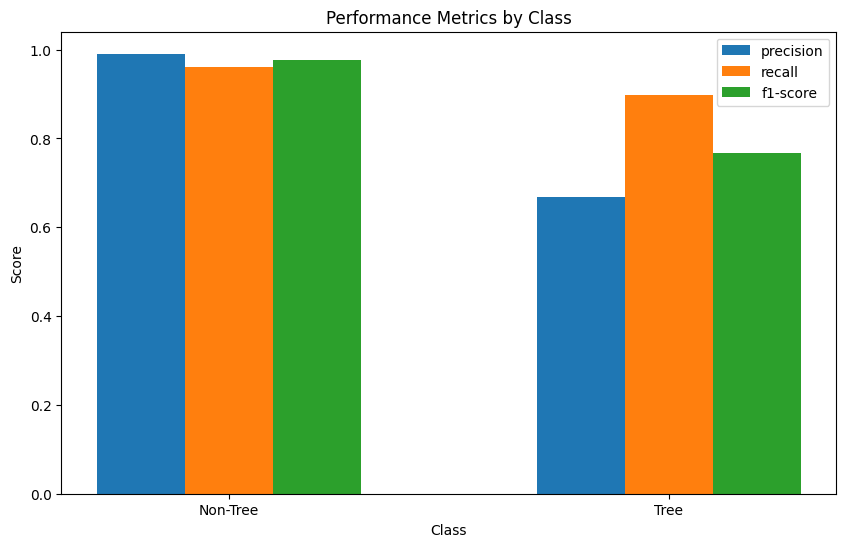

In [58]:
# Extract keys for classes dynamically from the report
classes = [key for key in report.keys() if key not in ['accuracy', 'macro avg', 'weighted avg']]

# Create a dictionary of values for precision, recall, and f1-score
metrics = ['precision', 'recall', 'f1-score']
values = {metric: [report[cls][metric] for cls in classes] for metric in metrics}

# Plot bar chart
x = np.arange(len(classes))  # Class label locations
width = 0.2  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Add bars for each metric
for i, metric in enumerate(metrics):
    ax.bar(x + i * width, values[metric], width, label=metric)

# Add labels and titles
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics by Class')
ax.set_xticks(x + width)
ax.set_xticklabels(classes)
ax.legend()

plt.show()


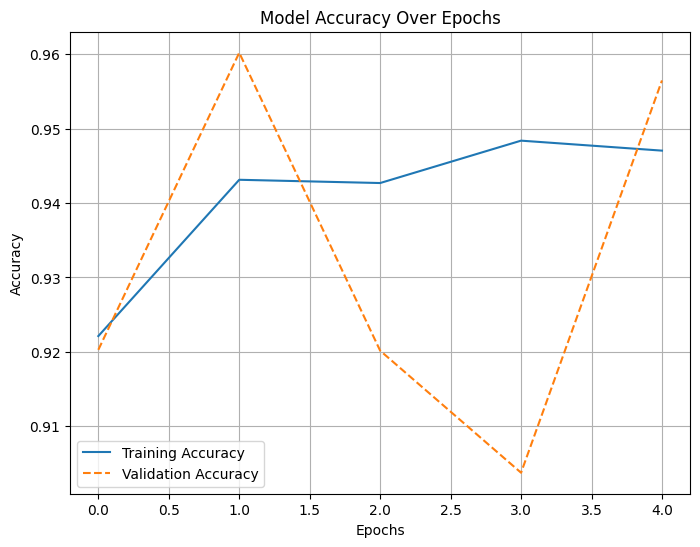

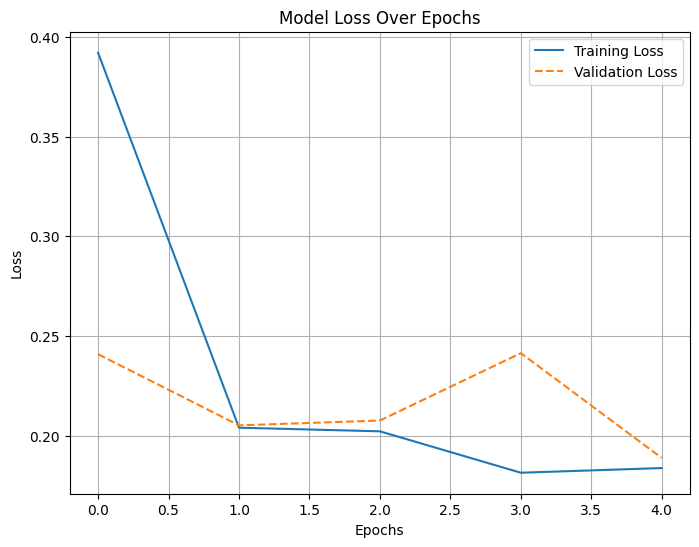

In [59]:
# Ensure you have the `history` object from model training

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Year: 2016, Number of Trees: 40


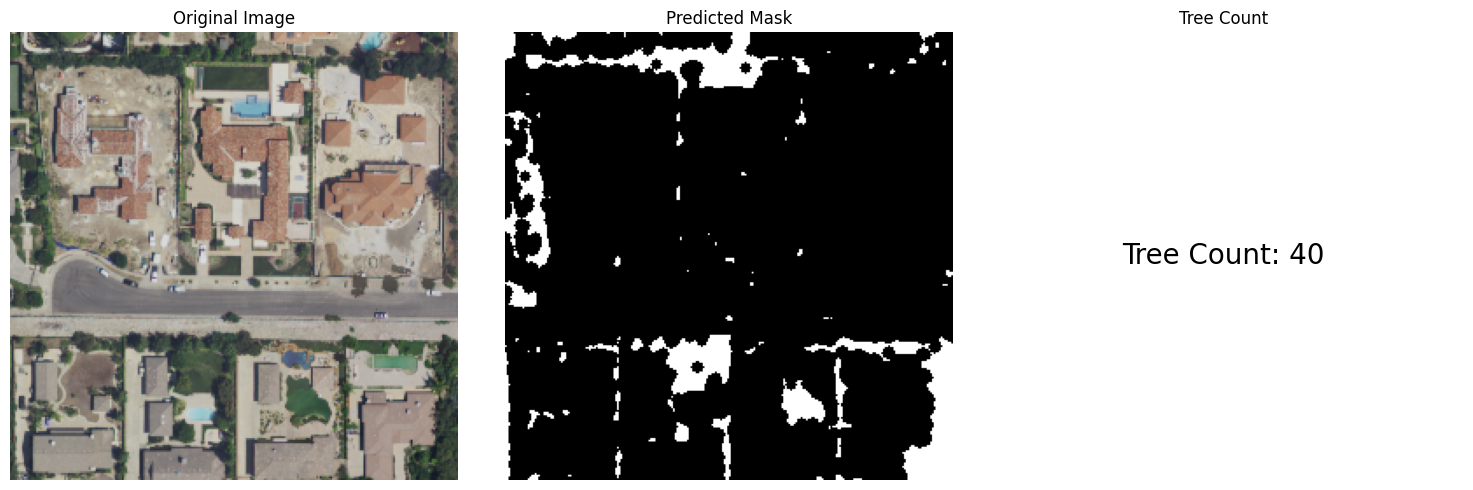

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Year: 2018, Number of Trees: 32


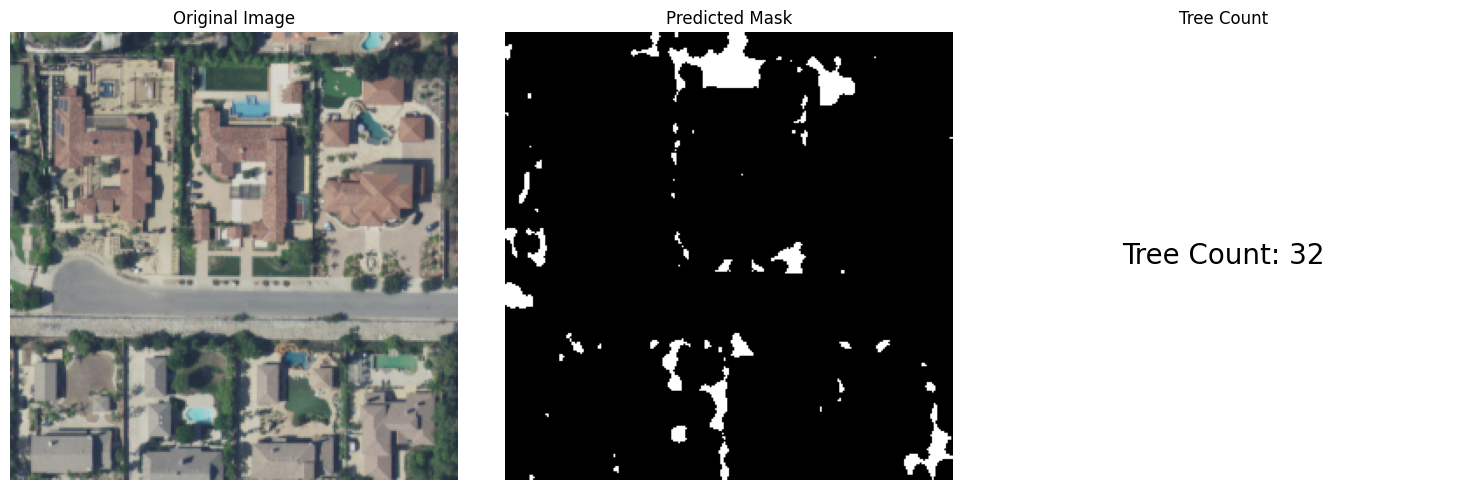

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Year: 2020, Number of Trees: 38


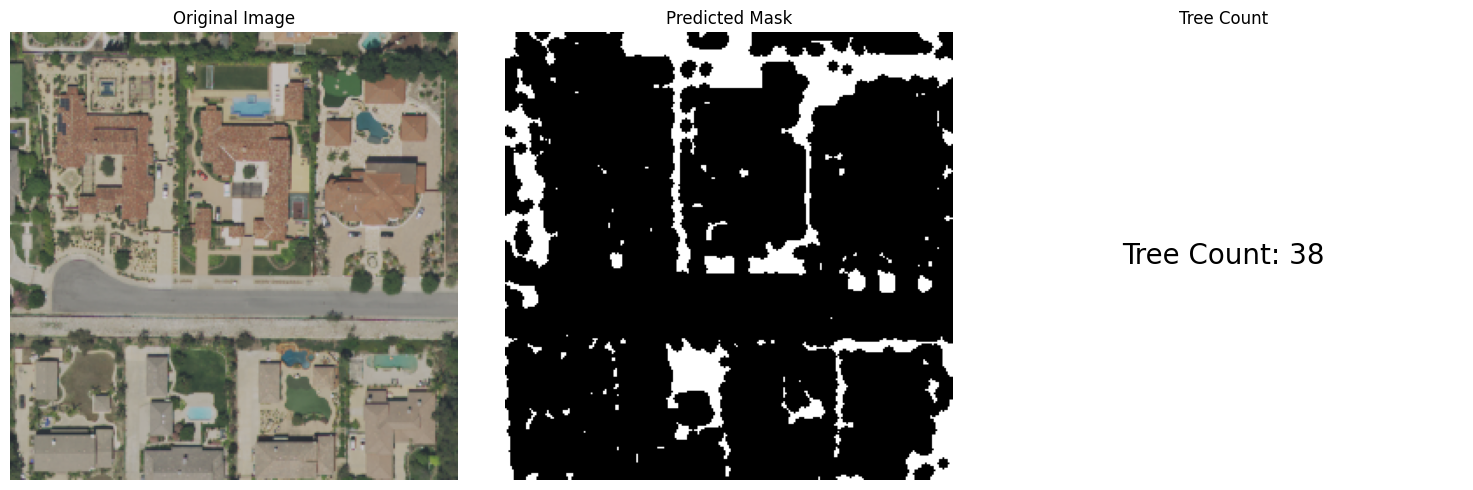

Deforestation detected between 2016 and 2018: 8 trees lost.
Tree growth detected between 2018 and 2020: 6 trees gained.
Overall observation: Deforestation occurred during the analyzed period.


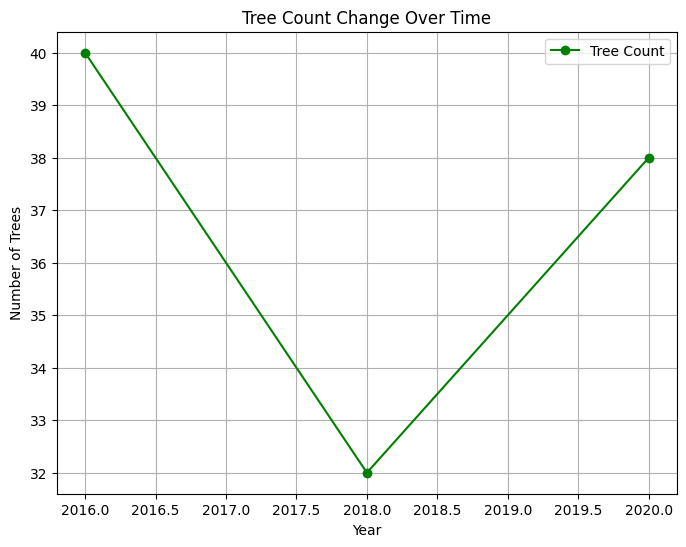

In [60]:
# Initialize a dictionary to store tree counts by year
tree_count_data = {}

def process_and_analyze_tree_counts(image_paths, model):
    """
    Processes images for the provided years, predicts tree counts, and analyzes deforestation or growth.

    Args:
        image_paths (dict): Dictionary where keys are years and values are image paths.
        model: The trained model for tree mask prediction.
    """
    global tree_count_data  # Use the global dictionary to store counts
    tree_count_data.clear()  # Clear any previous data to start fresh

    # Process each year and predict tree counts
    for year, path in image_paths.items():
        if not path:
            print(f"Skipping year {year}: No image provided.")
            continue

        try:
            # Predict the mask and count trees
            predicted_mask = predict_mask(path, model)
            tree_count = count_trees(predicted_mask)

            # Store the tree count in the dictionary
            tree_count_data[year] = tree_count

            # Display results
            print(f"Year: {year}, Number of Trees: {tree_count}")
            display_results(path, predicted_mask, tree_count)
        except Exception as e:
            print(f"Error processing image for year {year}: {e}")

    # Analyze tree count changes if multiple years are provided
    if len(tree_count_data) > 1:
        sorted_years = sorted(tree_count_data.keys())  # Ensure chronological order
        deforestation_detected = False
        overall_change = 0

        for i in range(len(sorted_years) - 1):
            year1, year2 = sorted_years[i], sorted_years[i + 1]
            change = tree_count_data[year2] - tree_count_data[year1]
            overall_change += change

            if change < 0:
                print(f"Deforestation detected between {year1} and {year2}: {-change} trees lost.")
                deforestation_detected = True
            elif change > 0:
                print(f"Tree growth detected between {year1} and {year2}: {change} trees gained.")
            else:
                print(f"No significant change in tree count between {year1} and {year2}.")

        # Summary statement
        if deforestation_detected:
            print("Overall observation: Deforestation occurred during the analyzed period.")
        else:
            print("Overall observation: No deforestation detected. Tree counts remained stable or increased.")
    else:
        print("Only one year submitted; deforestation analysis skipped.")

def plot_tree_count_change():
    """
    Plots tree count change dynamically based on the `tree_count_data`.
    """
    if not tree_count_data:
        print("No data available to plot. Please process images first.")
        return

    # Sort the data by year for a consistent timeline
    sorted_years = sorted(tree_count_data.keys())
    sorted_counts = [tree_count_data[year] for year in sorted_years]

    # Plot the graph
    plt.figure(figsize=(8, 6))
    plt.plot(sorted_years, sorted_counts, marker='o', color='green', label='Tree Count')
    plt.title('Tree Count Change Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Trees')
    plt.grid()
    plt.legend()
    plt.show()

# Example usage
image_paths = {
    2016: 'E:/tif images and csv/images/claremont_2016_2.tif',  # Replace with the actual path
    2018: 'E:/tif images and csv/images/claremont_2018_2.tif',  # Missing image for 2018
    2020: 'E:/tif images and csv/images/claremont_2020_2.tif'   # Replace with the actual path
}

# Process images and analyze tree counts
process_and_analyze_tree_counts(image_paths, unet_model)

# Plot the tree count change
plot_tree_count_change()
